# ONE dimensional

In [22]:
import numpy as np
%matplotlib inline

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt


def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(50000, 2, 1)
sample = list(zip(X, y))
class_two, class_neg_two = split_by_class(sample)

X, y = get_sample(50000, 4, 1)
sample = list(zip(X, y))
class_four, class_neg_four = split_by_class(sample)

X, y = get_sample(50000, 0, 1)
sample = list(zip(X, y))
class_zero, class_neg_zero = split_by_class(sample)

X, y = get_sample(50000, 8, 1)
sample = list(zip(X, y))
class_eight, class_neg_eight = split_by_class(sample)


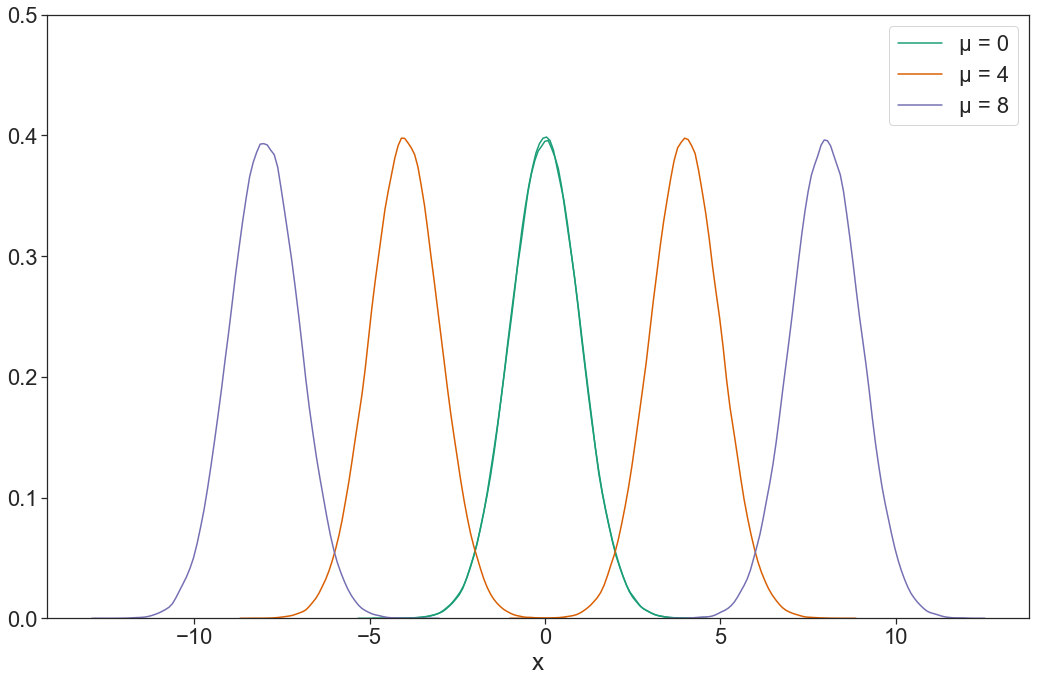

In [23]:
sns.set(font_scale = 2)
sns.set_style("ticks")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]
plt.figure()

sns.distplot(list(zip(*class_zero))[0], hist=False, color = "#1b9e77", label = u'\u03bc = 0')
sns.distplot(list(zip(*class_neg_zero))[0], hist=False, color = "#1b9e77")

sns.distplot(list(zip(*class_four))[0], hist=False, color = "#d95f02", label = u'\u03bc = 4')
sns.distplot(list(zip(*class_neg_four))[0], hist=False, color = "#d95f02")
plt.tight_layout()
sns.distplot(list(zip(*class_eight))[0], hist=False, color = "#7570b3", label = u'\u03bc = 8')
sns.distplot(list(zip(*class_neg_eight))[0], hist=False, color = "#7570b3")
plt.ylim(ymax = .5)
plt.xlabel("x")
plt.legend()
plt.tight_layout()
plt.savefig("1d_setting_final.png")
plt.show()

In [21]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

X, y = get_sample(1000, 0, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

#rf_entropy_estimate_bagging(X, y, 500, .32)


In [25]:
from scipy.stats import norm
from scipy.stats import multivariate_normal
import scipy.integrate as integrate
import math
from sklearn import mixture

def estimate_p(y):
    return y.count(1)/len(y)

def estimate_x_params(X):
    model = mixture.GaussianMixture(n_components = 2, covariance_type = "full")
    model.fit(X)
    return model.means_, model.covariances_
    
estimate_x_params(X)

def normal_entropy_f(t, mean, var):
    return -norm.pdf(t, mean, var)*np.log(norm.pdf(t, mean, var))

def two_mixture_normals_entropy_f(t, mean_1, mean_2, var_1, var_2):
    return -.5*norm.pdf(t, mean_1, var_1)*np.log(.5*norm.pdf(t, mean_1, var_1) + .5*norm.pdf(t, mean_2, var_2)) - .5*norm.pdf(t, mean_1, var_1)*np.log(.5*norm.pdf(t, mean_1, var_1) + .5*norm.pdf(t, mean_2, var_2))

def normal_entropy(var):
    return .5*np.log(2*math.pi*math.e*var)

#NOTE: this doesn't work for mean = 0
def plugin_estimate_cat_1D(X, y):
    y_param = estimate_p(y)
    x_params = estimate_x_params(X)
    h_y = -y_param*np.log(y_param) - (1 - y_param)*np.log(1 - y_param)
    #h_x_cond_y = integrate.quad(normal_entropy_f, -20, 20, args = (x_params[0][0], x_params[1][0].item()))[0]*.5 + \
    #integrate.quad(normal_entropy_f, -20, 20, args = (x_params[0][1], x_params[1][1].item()))[0]*.5
    h_x_cond_y = normal_entropy(x_params[1][0])*.5 + normal_entropy(x_params[1][1])*.5
    h_x = integrate.quad(two_mixture_normals_entropy_f, -20, 20, args = (x_params[0][0], x_params[0][1], x_params[1][0].item(), x_params[1][1].item()))[0]
    cond_entropy =  h_y - h_x + h_x_cond_y
    if cond_entropy < 0:
        return np.array((0))
    return cond_entropy

def truth_1d(mean):
    h_y = -.5*np.log(.5) - .5*np.log(.5)
    h_x_cond_y = normal_entropy(1)*.5 + normal_entropy(1)*.5
    h_x = integrate.quad(two_mixture_normals_entropy_f, -20, 20, args = (mean, -mean, 1, 1))[0]
    cond_entropy =  h_y - h_x + h_x_cond_y
    if cond_entropy < 0:
        return np.array((0))
    return cond_entropy



In [26]:
from tqdm import tqdm_notebook

def get_cond_entropy_vs_n(mean):
    cef_all = []
    plugin_all = []
    sample_sizes = [i*200 for i in range(1, 26)]
    for i in tqdm_notebook(range(5)):
        cef = []
        plugin = []
        for elem in tqdm_notebook(sample_sizes):
            X, y = get_sample(elem, mean, 1)
            cef.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
            plugin.append(plugin_estimate_cat_1D(np.array(X).reshape(-1, 1), y).item())
        cef_all.append(cef)
        plugin_all.append(plugin)
    return sample_sizes, cef_all, plugin_all

In [27]:
import pickle

sample_sizes, cef, plugin = get_cond_entropy_vs_n(1)
pickle.dump({"sample_sizes": sample_sizes, "cef": cef, "plugin": plugin}, open("cat_mean1_conv_truth.p", "wb"))



In [31]:
plugin = np.array(plugin)
avg_plugin = np.mean(plugin, axis = 0)
std_plugin = np.std(plugin, axis = 0)

cef = np.array(cef)
avg_cef = np.mean(cef, axis = 0)
std_cef = np.std(cef, axis = 0)

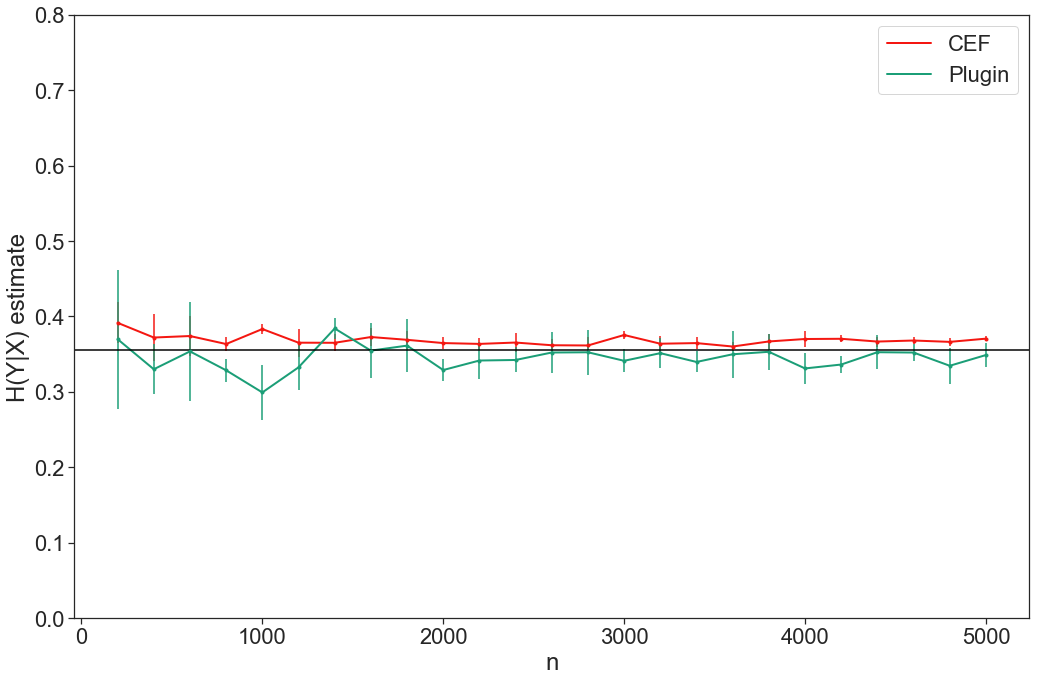

In [36]:
sns.set(font_scale = 2)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

line_cef, = plt.plot(sample_sizes, avg_cef, label = "CEF", linewidth = 2, color = "#F41711")
plt.errorbar(sample_sizes, avg_cef, std_cef, fmt = ".", color = "#F41711")

line_plugin, = plt.plot(sample_sizes, avg_plugin, label = "Plugin", linewidth = 2, color = "#1b9e77")
plt.errorbar(sample_sizes, avg_plugin, std_plugin, fmt = ".", color = "#1b9e77")


line_true = plt.axhline(y=.356,linestyle='-', color = "black", label = "Truth")

plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.ylim(ymin = 0)
plt.ylim(ymax = .8)
plt.legend(handles=[line_cef, line_plugin])
#plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.tight_layout()
plt.savefig("cat_mean1_1d_final.png")
plt.show()

In [29]:
def get_cond_entropy_vs_mu(n):
    cef_all = []
    plugin_all = []
    truth = []
    means = [i*.2 for i in range(1, 26)]
    for i in tqdm_notebook(range(5)):
        cef = []
        plugin = []
        for elem in tqdm_notebook(means):
            X, y = get_sample(n, elem, 1)
            cef.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
            plugin.append(plugin_estimate_cat_1D(np.array(X).reshape(-1, 1), y).item())
        cef_all.append(cef)
        plugin_all.append(plugin)
        
    for elem in means:
        truth.append(truth_1d(elem))
    return means, cef_all, plugin_all, truth

In [30]:
means, cef_means, plugin_means, truth = get_cond_entropy_vs_mu(4000)
pickle.dump({"sample_sizes": sample_sizes, "cef": cef_means, "plugin": plugin_means}, open("cat_n4000_conv_0.p", "wb"))


In [35]:
plugin_means = np.array(plugin_means)
avg_plugin_means = np.mean(plugin_means, axis = 0)
std_plugin_means = np.std(plugin_means, axis = 0)

cef_means = np.array(cef_means)
avg_cef_means = np.mean(cef_means, axis = 0)
std_cef_means = np.std(cef_means, axis = 0)

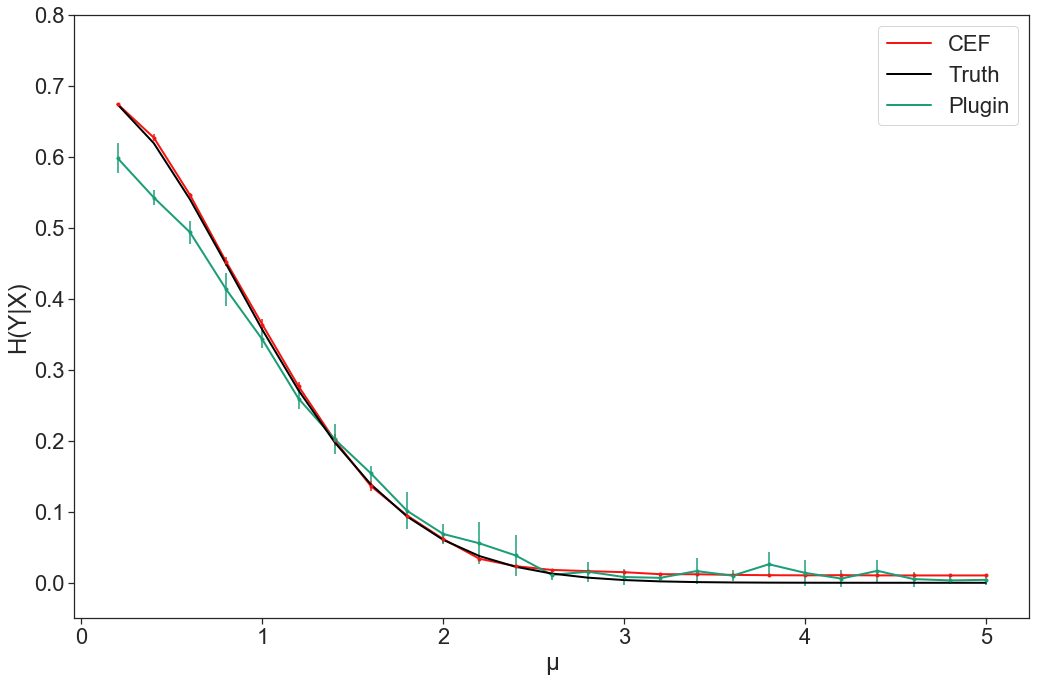

In [40]:
sns.set(font_scale = 2)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

line_cef, = plt.plot(means, avg_cef_means, label = "CEF", linewidth = 2, color = "#F41711")
plt.errorbar(means, avg_cef_means, std_cef_means, fmt = ".", color = "#F41711")

line_plugin, = plt.plot(means, avg_plugin_means, label = "Plugin", linewidth = 2, color = "#1b9e77")
plt.errorbar(means, avg_plugin_means, std_plugin_means, fmt = ".", color = "#1b9e77")


line_true, = plt.plot(means, truth, label = "Truth", linewidth = 2, color = 'black')

plt.ylim(ymin = -.05)
plt.ylim(ymax = .8)
plt.legend(handles=[line_cef, line_true, line_plugin])
plt.xlabel(u'\u03bc')
plt.ylabel("H(Y|X)")
plt.tight_layout()
plt.savefig("cat_1d_n4000_conv0_final.png")
plt.show()